# Model BiLSTM + CRF

## Import Library

In [1]:
import pandas as pd
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
from torchcrf import CRF  # Install via `pip install pytorch-crf`
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
import torch
import pickle
from sklearn.metrics import classification_report

## Model BILSTM+CRF

### Read file CSV and Loading data

In [2]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    for _, row in data.iterrows():
        token = row['token']
        label = row['label']
        
        # Check if the row marks the end of a sentence (if applicable)
        if pd.isna(token):  # Use NaN or other criteria to split sentences
            if current_sentence:
                sentences.append(current_sentence)
                labels.append(current_labels)
                current_sentence = []
                current_labels = []
        else:
            current_sentence.append(token)
            current_labels.append(label)

    # Add the last sentence if it's not empty
    if current_sentence:
        sentences.append(current_sentence)
        labels.append(current_labels)

    return sentences, labels

# Load train, test, and dev data
train_sentences, train_labels = load_data('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_train.csv')
test_sentences, test_labels = load_data('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_test.csv')
dev_sentences, dev_labels = load_data('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_dev.csv')

print(f"Loaded {len(train_sentences)} training sentences.")
print(f"First training sentence: {train_sentences[0]}")
print(f"First training sentence labels: {train_labels[0]}")


Loaded 1 training sentences.
First training sentence: ['In', 'this', 'article', 'we', 'discuss', 'several', 'metrics', 'of', 'coherence', 'defined', 'using', 'centering', 'theory', 'and', 'investigate', 'the', 'usefulness', 'of', 'such', 'metrics', 'for', 'information', 'ordering', 'in', 'automatic', 'text', 'generation', '.', 'We', 'estimate', 'empirically', 'which', 'is', 'the', 'most', 'promising', 'metric', 'and', 'how', 'useful', 'this', 'metric', 'is', 'using', 'a', 'general', 'methodology', 'applied', 'on', 'several', 'corpora', '.', 'Our', 'main', 'result', 'is', 'that', 'the', 'simplest', 'metric', '(', 'which', 'relies', 'exclusively', 'on', 'NOCB', 'transitions', ')', 'sets', 'a', 'robust', 'baseline', 'that', 'cannot', 'be', 'outperformed', 'by', 'other', 'metrics', 'which', 'make', 'use', 'of', 'additional', 'centering', 'based', 'features', '.', 'This', 'baseline', 'can', 'be', 'used', 'for', 'the', 'development', 'of', 'both', 'text', 'to', 'text', 'and', 'concept', 'to'

In [3]:
# Load dataset
data_train = pd.read_csv('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_train.csv')
data_test = pd.read_csv('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_test.csv')
data_dev = pd.read_csv('/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project/data/cleaned_data/cleaned_data_dev.csv')

print("Data for training ========\n", data_train.shape)
print("Data for test =========\n", data_test.shape)
print("Data for dev ========\n", data_dev.shape)

Data for training ========
 (26742, 3)
Data for test =========
 (3899, 3)
Data for dev ========
 (3292, 3)


### Function for building a vocabulary

In [4]:
# Function to build a vocabulary from the tokenized sentences
def build_vocab(data, special_tokens=["<PAD>", "<UNK>"]):
    vocab = Counter([token for sentence in data for token in sentence])
    word_to_idx = {token: idx for idx, (token, _) in enumerate(vocab.items(), start=len(special_tokens))}
    
    # Add special tokens
    for idx, token in enumerate(special_tokens):
        word_to_idx[token] = idx
    
    return word_to_idx

In [5]:
# Function to build a tag vocabulary from the label sequences
def build_tag_vocab(labels, special_tags=["<PAD>"]):
    unique_labels = set(tag for label_seq in labels for tag in label_seq)
    tag_to_idx = {tag: idx for idx, tag in enumerate(unique_labels, start=len(special_tags))}
    
    # Add special tags
    for idx, tag in enumerate(special_tags):
        tag_to_idx[tag] = idx
    
    return tag_to_idx

In [6]:
# Build vocabularies
word_to_idx = build_vocab(train_sentences)
tag_to_idx = build_tag_vocab(train_labels)

print(f"Word vocab size: {len(word_to_idx)}")
print(f"Tag vocab size: {len(tag_to_idx)}")

Word vocab size: 3865
Tag vocab size: 4


### Function to encode sentences and labels into numerical format

In [7]:
# Function to encode sentences and labels into numerical format using vocabularies
def encode_data(sentences, labels, word_to_idx, tag_to_idx):
    encoded_sentences = [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]
    encoded_labels = [[tag_to_idx[label] for label in label_seq] for label_seq in labels]
    return encoded_sentences, encoded_labels

In [8]:
# Encode the training, test, and dev datasets using the vocabularies built earlier
train_sentences_encoded, train_labels_encoded = encode_data(train_sentences, train_labels, word_to_idx, tag_to_idx)
test_sentences_encoded, test_labels_encoded = encode_data(test_sentences, test_labels, word_to_idx, tag_to_idx)
dev_sentences_encoded, dev_labels_encoded = encode_data(dev_sentences, dev_labels, word_to_idx, tag_to_idx)

# Print the first encoded sentence and its corresponding labels for verification
print(f"First encoded training sentence: {train_sentences_encoded[0]}")
print(f"First encoded training labels: {train_labels_encoded[0]}")

First encoded training sentence: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 9, 19, 8, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 17, 33, 34, 35, 15, 36, 37, 3, 35, 32, 12, 38, 39, 40, 41, 42, 7, 43, 27, 44, 45, 46, 32, 47, 17, 48, 35, 49, 31, 50, 51, 42, 52, 53, 54, 55, 38, 56, 57, 47, 58, 59, 60, 61, 62, 8, 31, 63, 64, 9, 65, 13, 66, 67, 27, 68, 57, 69, 59, 70, 20, 17, 71, 9, 72, 25, 73, 25, 15, 74, 73, 25, 26, 75, 76, 77, 78, 49, 79, 54, 75, 80, 81, 82, 83, 27, 2, 84, 85, 17, 86, 87, 88, 75, 89, 73, 59, 90, 73, 91, 92, 27, 93, 94, 9, 95, 17, 96, 9, 17, 97, 78, 98, 49, 79, 99, 100, 101, 54, 32, 73, 102, 17, 100, 103, 104, 105, 17, 78, 98, 106, 85, 107, 108, 17, 79, 109, 73, 47, 9, 110, 111, 78, 27, 68, 112, 113, 114, 115, 98, 23, 31, 17, 100, 116, 117, 32, 118, 23, 17, 119, 120, 2, 121, 122, 85, 38, 123, 9, 17, 78, 32, 124, 49, 125, 126, 127, 54, 61, 17, 100, 15, 17, 128, 129, 130, 131, 49, 126, 132, 131, 54, 78, 133, 134, 73, 135, 3, 123, 27, 93, 136, 137, 

### Function to pad sentences and labels

In [9]:
# Function to pad sentences and labels to the same length and create a mask
def pad_data(sentences, labels, pad_idx=0):
    sentences_padded = pad_sequence([torch.tensor(seq) for seq in sentences], batch_first=True, padding_value=pad_idx)
    labels_padded = pad_sequence([torch.tensor(seq) for seq in labels], batch_first=True, padding_value=pad_idx)
    mask = (sentences_padded != pad_idx)  # Create a mask for valid tokens
    return sentences_padded, labels_padded, mask


In [10]:
# Pad the training, test, and dev datasets with the <PAD> token's index
train_sentences_padded, train_labels_padded, train_mask = pad_data(train_sentences_encoded, train_labels_encoded, pad_idx=word_to_idx["<PAD>"])
test_sentences_padded, test_labels_padded, test_mask = pad_data(test_sentences_encoded, test_labels_encoded, pad_idx=word_to_idx["<PAD>"])
dev_sentences_padded, dev_labels_padded, dev_mask = pad_data(dev_sentences_encoded, dev_labels_encoded, pad_idx=word_to_idx["<PAD>"])

# Optional: Print the shapes of the padded sequences and masks to check the result
print(f"Shape of padded training sentences: {train_sentences_padded.shape}")
print(f"Shape of padded training labels: {train_labels_padded.shape}")
print(f"Shape of training mask: {train_mask.shape}")

Shape of padded training sentences: torch.Size([1, 26742])
Shape of padded training labels: torch.Size([1, 26742])
Shape of training mask: torch.Size([1, 26742])


### Defined Architecture of BiLSTM+CRF model

In [11]:
# BiLSTM-CRF Model for Sequence Labeling
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, pad_idx):
        """
        Initializes the BiLSTM-CRF model with the specified parameters.

        Args:
        - vocab_size (int): Size of the vocabulary (number of unique words in the dataset).
        - tagset_size (int): Number of unique tags (labels) in the dataset.
        - embedding_dim (int): Dimension of word embeddings.
        - hidden_dim (int): Number of features in the hidden state of the BiLSTM (should be divisible by 2 for bidirectional).
        - pad_idx (int): Index used for padding in the word embeddings.
        """
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size
        self.pad_idx = pad_idx

        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # 2. BiLSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        # 3. Linear Layer (maps LSTM output to tag space)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # 4. CRF Layer
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags, mask):
        # 1. Embedding
        embeddings = self.embedding(sentences)

        # 2. BiLSTM
        lstm_out, _ = self.lstm(embeddings)

        # 3. Project LSTM outputs to tag space
        emissions = self.hidden2tag(lstm_out)

        # 4. CRF Loss (negative log likelihood)
        loss = -self.crf(emissions, tags, mask=mask)
        return loss

    def predict(self, sentences, mask):
        # 1. Embedding
        embeddings = self.embedding(sentences)

        # 2. BiLSTM
        lstm_out, _ = self.lstm(embeddings)

        # 3. Project LSTM outputs to tag space
        emissions = self.hidden2tag(lstm_out)

        # 4. CRF Decoding (predict best tag sequence)
        predictions = self.crf.decode(emissions, mask=mask)
        return predictions


In [12]:
# Hyperparameters
EMBEDDING_DIM = 100  # Size of word embeddings
HIDDEN_DIM = 256     # Size of LSTM hidden states
VOCAB_SIZE = len(word_to_idx)
TAGSET_SIZE = len(tag_to_idx)
PAD_IDX = word_to_idx["<PAD>"]

# Initialize the model
model = BiLSTM_CRF(vocab_size=VOCAB_SIZE, 
                   tagset_size=TAGSET_SIZE, 
                   embedding_dim=EMBEDDING_DIM, 
                   hidden_dim=HIDDEN_DIM, 
                   pad_idx=PAD_IDX)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BiLSTM_CRF(
  (embedding): Embedding(3865, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=4, bias=True)
  (crf): CRF(num_tags=4)
)

### Function create data loader

In [13]:
def create_dataloader(sentences, labels, mask, batch_size=32):
    """
    Creates a DataLoader for batching the input data during training, testing, or evaluation.

    Args:
    - sentences (Tensor): A tensor of padded sentences (size: batch_size x seq_length).
    - labels (Tensor): A tensor of padded labels (size: batch_size x seq_length).
    - mask (Tensor): A mask tensor that indicates the valid tokens in the sentences (size: batch_size x seq_length).
    - batch_size (int, optional): The batch size to use when creating the DataLoader. Default is 32.

    Returns:
    - DataLoader: A DataLoader object that will load batches of data for training or evaluation.
    """
    # Create a TensorDataset object that combines the sentences, labels, and mask tensors into a dataset.
    # TensorDataset allows for efficient access to the tensors when iterating through the data.
    dataset = TensorDataset(sentences, labels, mask)

    # Create a DataLoader from the dataset. The DataLoader handles batching and shuffling of the data.
    # shuffle=True means the data will be shuffled before each epoch, ensuring randomness in training.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [14]:
# Create DataLoaders for training, testing, and validation datasets
train_dataloader = create_dataloader(train_sentences_padded, train_labels_padded, train_mask)
test_dataloader = create_dataloader(test_sentences_padded, test_labels_padded, test_mask)
dev_dataloader = create_dataloader(dev_sentences_padded, dev_labels_padded, dev_mask)

### Summary of Training

In [15]:
# Initialize lists to store losses for plotting
train_losses = []  # To store training losses at each epoch
val_losses = []    # To store validation losses at each epoch

# Define optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training loop
EPOCHS = 40 # Set the number of epochs for training
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    total_train_loss = 0 # Variable to accumulate training loss

    # Training phase
    for sentences, tags, mask in train_dataloader:
        # Move data to the GPU (if available) for faster processing
        sentences, tags, mask = sentences.to(device), tags.to(device), mask.to(device)
        # Zero the gradients from the previous step
        optimizer.zero_grad()
        # Forward pass: compute the loss
        loss = model(sentences, tags, mask)
        # Backward pass: compute gradients
        loss.backward()
        # Update the model's parameters
        optimizer.step()
        # Accumulate training loss
        total_train_loss += loss.item()

    # Validation phase
    model.eval() # Set model to evaluation mode
    total_val_loss = 0 # Variable to accumulate validation loss

    with torch.no_grad(): # Disable gradient computation during evaluation
        for sentences, tags, mask in dev_dataloader:
            # Move data to the GPU (if available)
            sentences, tags, mask = sentences.to(device), tags.to(device), mask.to(device)
            # Forward pass for validation data
            val_loss = model(sentences, tags, mask)
            # Accumulate validation loss
            total_val_loss += val_loss.item()
            
    # Calculate the average training and validation losses for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(dev_dataloader)

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print losses
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")


/Users/makchanna128gmail.com/Documents/CADT_CS/Y6/NLP/Project_text/NER_Project_mine/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
  Training Loss: 38357.5039
  Validation Loss: 4558.9292
Epoch 2/40
  Training Loss: 36984.5547
  Validation Loss: 4399.6216
Epoch 3/40
  Training Loss: 35669.2305
  Validation Loss: 4243.4976
Epoch 4/40
  Training Loss: 34380.0117
  Validation Loss: 4086.9688
Epoch 5/40
  Training Loss: 33084.7891
  Validation Loss: 3926.7161
Epoch 6/40
  Training Loss: 31759.9160
  Validation Loss: 3760.1377
Epoch 7/40
  Training Loss: 30382.2402
  Validation Loss: 3585.1379
Epoch 8/40
  Training Loss: 28932.4844
  Validation Loss: 3400.3137
Epoch 9/40
  Training Loss: 27404.8320
  Validation Loss: 3205.8430
Epoch 10/40
  Training Loss: 25804.1211
  Validation Loss: 3004.8645
Epoch 11/40
  Training Loss: 24162.9609
  Validation Loss: 2805.1838
Epoch 12/40
  Training Loss: 22574.1152
  Validation Loss: 2626.3547
Epoch 13/40
  Training Loss: 21259.3379
  Validation Loss: 2506.7019
Epoch 14/40
  Training Loss: 20602.7871
  Validation Loss: 2496.0073
Epoch 15/40
  Training Loss: 21034.8008
  V

### Plot graph training and validation loss

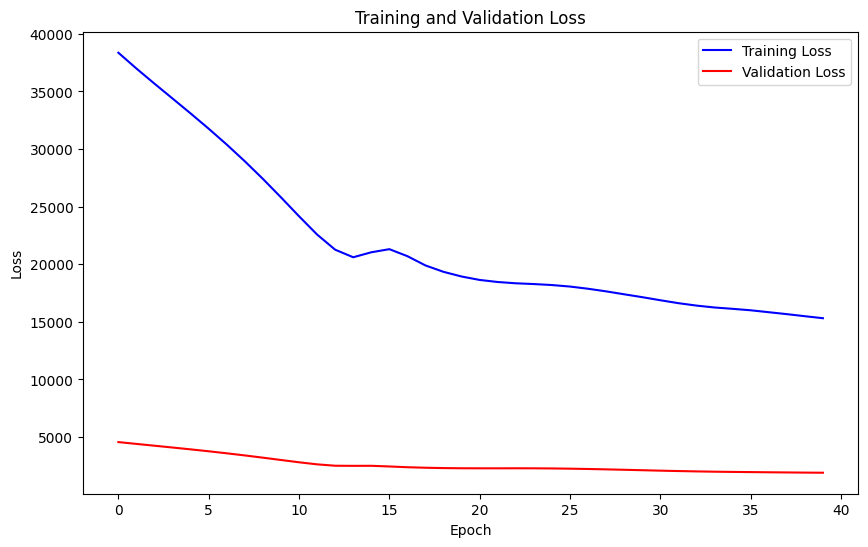

In [16]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Evaluation

In [17]:

#  Function to evaluate the performance of the BiLSTM-CRF model
def evaluate(model, dataloader, tag_to_idx):
    """
    Function to evaluate the performance of the BiLSTM-CRF model on a given dataloader.
    It computes the predictions and compares them with the true labels using a classification report.

    Args:
    - model: The trained BiLSTM-CRF model.
    - dataloader: DataLoader containing the evaluation data (e.g., validation or test set).
    - tag_to_idx: Dictionary mapping tags to their corresponding indices.
    """
    # Convert tag indices to tags for later reference in evaluation
    idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
    # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()

    # Initialize lists to store all predictions and true labels
    all_preds = []
    all_labels = []

    # Disable gradient calculation to save memory and computation during evaluation
    with torch.no_grad():
        # Iterate over batches in the dataloader
        for sentences, tags, mask in dataloader:
            # Move data to GPU (if available)
            sentences, tags, mask = sentences.to(device), tags.to(device), mask.to(device)

            # Get predictions
            predictions = model.predict(sentences, mask)

            # Flatten predictions and labels
            for pred, true, m in zip(predictions, tags, mask):
                # Remove padding tokens from both predictions and true labels
                pred = pred[:m.sum()]  # Remove padding predictions
                true = true[:m.sum()]  # Remove padding labels
                 # Convert predictions and true labels to their string tag equivalents
                all_preds.extend([idx_to_tag[p] for p in pred]) # Convert predicted indices to tags
                all_labels.extend([idx_to_tag[t.item()] for t in true]) # Convert true indices to tags

    # Print out the classification report (precision, recall, F1 score for each tag)
    print(classification_report(all_labels, all_preds))

# Evaluate on dev set
evaluate(model, dev_dataloader, tag_to_idx)


              precision    recall  f1-score   support

           B       0.67      0.02      0.04       394
           I       0.65      0.34      0.45       399
           O       0.80      0.98      0.88      2499

    accuracy                           0.79      3292
   macro avg       0.71      0.45      0.46      3292
weighted avg       0.76      0.79      0.73      3292



### Save model

In [18]:
# After the training loop finishes, save the model's state_dict to a file
# Save the model's state_dict (parameters) to a file (with .plk extension)
torch.save(model.state_dict(), "bilstm_crf_model.plk")
print("Model saved as bilstm_crf_model.plk")

Model saved as bilstm_crf_model.plk


### Loading the Model

In [19]:
# Initialize the model again with the same architecture
loaded_model = BiLSTM_CRF(vocab_size=len(word_to_idx), 
                           tagset_size=len(tag_to_idx), 
                           embedding_dim=100, 
                           hidden_dim=256, 
                           pad_idx=word_to_idx["<PAD>"])

# Load the model's parameters from the saved file
loaded_model.load_state_dict(torch.load('bilstm_crf_model.plk'), strict=False)

# Move the loaded model to the appropriate device (CPU or GPU)
loaded_model.to(device)

print("Model loaded successfully")


Model loaded successfully


/var/folders/72/vzkxgk9s7fq49mr_t97r12ch0000gn/T/ipykernel_88929/3308567646.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('bils